# [Rainforest Connecton Species Audio Detection Challenge](https://www.kaggle.com/competitions/rfcx-species-audio-detection/data) was a machine learning Kaggle competition to detect species from their audio recordings. 

# Aim

Given audio files that include sounds from numerous species, the objective is to use machine learning to predict species in the audio clip. 

# Data Description
Each audio recording is 5 mins long. There are total of 3958 audio recording files availabe for training. 
Each single recorded audio contains signals from multiple species which are labelled by time-stamps `t_min` and `t_max`, where `t_min` indicates the start time the a particular species was heard and  `t_max` the time until the species was heard. Also provided are frequency range(`f_min`, `f_max`) of that particular siganl. 


Training data also includes false positive label occurrences to assist with training.

Files: 

- `train_tp.csv` - training data of true positive species labels, with corresponding time localization.
- `train_fp.csv` - training data of false positives species labels, with corresponding time localization
- `train/` - the training audio files
- `test/` - the test audio files; the task is to predict the species found in each audio file

The meta file `train_tp.csv` contains the following columns:

- `recording_id` - unique identifier for recording
- `species_id` - unique identifier for species
- `songtype_id` - unique identifier for songtype
- `t_min` - start second of annotated signal
- `f_min` - lower frequency of annotated signal
- `t_max` - end second of annotated signal
- `f_max` - upper frequency of annotated signal

# Approach:

Past studies showed that rather than directly use the audio signals for species detection, instead using images of mel-spectrogram of the audio signals can be  used train deep learning models to perform species identification. The approach used in this notebook is the same. 


Since EDA indicates that each signal is approx. `2.64 sec` long. The plan is to chop each audio recordings (each `5 min` long) into `10 sec` long clips. 
Then plot the Mel-spectrogram, and save it as images which could be then be used to train deep learning models. There are a total of 24 different species that haven been labelled.  

This notebook illustrates how the audio recordings can be preprocessed to generate images of mel-spectrogram, and  how these images can used to detect species using a deep-learning model. 

# Import libraries

In [1]:
import os
import gc
import time
import shutil
import random
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


import torch
import torch.nn as nn 
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Libraries for handling dataset
from torch.utils.data import Dataset as BaseDataset, DataLoader

# LR Scheduler
from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

from torchvision import transforms 

# Load pretrained computer-vision model
from torchvision.models.resnet import resnet18, resnet34, resnet50

# Libraries for handling audio files
import librosa as lb  

# Libraries for plotting Spectrograms from audio signals
# from audiomentations import *

# Libraries for handling images
import skimage.io
from skimage import transform

print(lb.__version__)
#print(python.__version__)

warnings.filterwarnings("ignore")

0.9.2


# Quick EDA

In [2]:
# Review rfcx-species-detection challenge 

import numpy as np
import pandas as pd

path = '../input/rfcx-species-audio-detection'
train_csv = pd.read_csv(path + '/train_fp.csv')

display(train_csv.head())

rec_ids = train_csv.recording_id.unique()
print(rec_ids, '# Number of recordings = ', len(rec_ids))

species_ids = train_csv.species_id.unique()
print(species_ids, '# Number of species = ', len(species_ids))

# Compute average duration of signal
train_csv['signal_duration'] = train_csv.t_max - train_csv.t_min
display(train_csv.describe().transpose())

avg_signal_duration = train_csv.signal_duration.mean()
print('Avg signal duration (sec)', avg_signal_duration)

print('Number of species =', train_csv.species_id.nunique())

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,00204008d,21,1,13.8400,3281.2500,14.9333,4125.0000
1,00204008d,8,1,24.4960,3750.0000,28.6187,5531.2500
2,00204008d,4,1,15.0027,2343.7500,16.8587,4218.7500
3,003b04435,22,1,43.2533,10687.5000,44.8587,13687.5000
4,003b04435,23,1,9.1254,7235.1562,15.2091,11283.3984


['00204008d' '003b04435' '005f1f9a5' ... 'ffebe7313' 'fff163132'
 'fffb79246'] # Number of recordings =  3958
[21  8  4 22 23 10  2  1 11 19 20 17  9 15 16  6  5  3 18 12  0 13 14  7] # Number of species =  24


,count,mean,std,min,25%,50%,75%,max
species_id,7781.0,12.138671,7.068808,0.0000,6.0000,12.0000,18.0000,23.0000
songtype_id,7781.0,1.346999,0.959535,1.0000,1.0000,1.0000,1.0000,4.0000
t_min,7781.0,28.627830,17.461603,0.0107,12.9493,28.8800,44.0657,59.3013
f_min,7781.0,2827.996428,2515.604420,93.7500,947.4609,2343.7500,3843.7500,10687.5000
t_max,7781.0,31.267911,17.496989,0.7680,15.7280,31.5413,46.7893,59.9947
f_max,7781.0,6074.830415,3386.040304,843.7500,3937.5000,5250.0000,7500.0000,13687.5000
signal_duration,7781.0,2.640081,1.820595,0.2720,1.2906,2.1440,3.3440,7.9239


Avg signal duration (sec) 2.640081403418584
Number of species = 24


# class `Preprocessing`

In [3]:
class Preprocessing:
    
    sample_length = 5 
    sampling_rate = 48000
    image_size = (224, 224)
    AUDIO_FOLDER = '../input/rfcx-species-audio-detection'
   
    def __init__(self, meta_data):
        self.META_FILE = meta_data
        
    def train_data(self, OUTPUT_IMAGE_FOLDER = 'TRAIN_IMAGES'):
        '''
        PREPROCESSING: AUDIO SIGNAL --> IMAGE.
        Preprocessing steps: 
        1. Uses package librosa to load the audio file as a numpy array.
        2. Select the sample duration from the audio-file.
        3. Plot the Mel-Spectrogram of the sample.
        4. Convert the MEL-spectrogram to image of desired size.
        5. Save the image.
        '''
        start_time = time.time()

        for idx in range(len(self.META_FILE)):
            record_id = self.META_FILE['recording_id'].iloc[idx] 
            label = self.META_FILE['species_id'].iloc[idx]

            # Use librosa to load the audio file as a numpy array...
            audio_filepath = f'{self.AUDIO_FOLDER}/train/{record_id}.flac'
            
            audio_data, _ = lb.load(audio_filepath, sr = self.sampling_rate) # sr -  sampling rate

            # Duration of signal is (t_max - t_min). 
            t_min = self.META_FILE['t_min'].iloc[idx] 
            t_max = self.META_FILE['t_max'].iloc[idx]

            # Select sample start time such that it contains the signal.
            sample_start_time =  (t_min + t_max) * 0.5 - self.sample_length * 0.5
            sample_end_time = sample_start_time + self.sample_length

            if sample_start_time < 0:
                sample_start_time = 0.
                sample_end_time = sample_start_time + self.sample_length

            if sample_end_time > (len(audio_data) / self.sampling_rate):
                sample_end_time = len(audio_data) / self.sampling_rate
                sample_start_time = sample_end_time - self.sample_length

            start_idx = int(sample_start_time * self.sampling_rate)
            end_idx = int(sample_end_time * self.sampling_rate)

            sample = audio_data[start_idx:end_idx]
            S = lb.feature.melspectrogram(sample, self.sampling_rate,  
                n_fft = 2048,                   # WINDOW LENGHT             
                hop_length = 512,               # WINDOW LENGHT // 4  
                n_mels = 128, 
                fmin = 0,                    
                fmax = self.sampling_rate // 2 # HALF THE SAMPLING RATE     
            )
            # Convert ot power
            D = lb.power_to_db(S, ref=np.max)

            # Resize the MEL-Spectrogram to image of (224x224)
            D = skimage.transform.resize(D, self.image_size)

            # Normalize the image
            D = D - D.min()
            D = D / (D.max() + 1.0e-10)        

            # Save image as np.array...
            if not Path(OUTPUT_IMAGE_FOLDER).exists():
                os.mkdir(OUTPUT_IMAGE_FOLDER)          
            path_train_images = Path(OUTPUT_IMAGE_FOLDER) / ('RID{}_SID{:0>2d}'.format(record_id, label))  
            np.save(path_train_images, D)
            
        print('Number of audio files for training:', len(self.META_FILE))
        print(f'TRAINING IMAGES SAVED TO FOLDER: {OUTPUT_IMAGE_FOLDER}')
        print('Number of training images: ', len(os.listdir(OUTPUT_IMAGE_FOLDER)))
        print('Image Size:', self.image_size)
        print('Processing time {:.2f} seconds'.format(time.time() - start_time ))

    def val_data(self, OUTPUT_IMAGE_FOLDER = 'VAL_IMAGES'):
        start_time = time.time()
        for idx in range(len(self.META_FILE)):    
                record_id = self.META_FILE['recording_id'].iloc[idx] 
                label = self.META_FILE['species_id'].iloc[idx]
                audio_file  = f'{self.AUDIO_FOLDER}/train/{record_id}.flac'
                audio_data, _ = lb.load(audio_file, sr = self.sampling_rate) 
                n_samples = len(audio_data) // (self.sample_length * self.sampling_rate)

                start_idx = 0
                end_idx = start_idx + (self.sample_length * self.sampling_rate)

                if len(audio_data) < self.sample_length * self.sampling_rate:
                    n_samples = 1
                    end_idx = len(audio_data) 

                for j in range(n_samples):
                    S = lb.feature.melspectrogram(audio_data[start_idx:end_idx], self.sampling_rate, n_fft = 2048, hop_length = 2048 // 4, n_mels = 128,
                                                  fmin = 0, fmax = self.sampling_rate // 2)
                    D = lb.power_to_db(S, ref= np.max)
                    # RESIZE
                    D = skimage.transform.resize(D, (224, 224))
                    # Normalize
                    D = D - D.min()
                    D = D / (D.max() + 1.0e-10)   
                    if not Path(OUTPUT_IMAGE_FOLDER).exists():
                        os.mkdir(OUTPUT_IMAGE_FOLDER)      
                    path_val_images = Path(OUTPUT_IMAGE_FOLDER) / ('RID{}_SID{:0>2d}_CLIP{:0>2d}'.format(record_id, label, j))  
                    np.save(path_val_images, D)
                    # Update the `start_idx` and `end_idx`
                    start_idx = end_idx
                    end_idx = start_idx + self.sample_length * self.sampling_rate
        print('') 
        print('Number of audio files for validation:', len(self.META_FILE))
        print(f'VALIDATION IMAGES SAVED TO FOLDER: {OUTPUT_IMAGE_FOLDER}')
        print('Number of validating images: ', len(os.listdir(OUTPUT_IMAGE_FOLDER)))
        print('Image Size:', self.image_size)
        print('Processing time {:.2f} seconds'.format(time.time() - start_time ))
        print('')

# Metric: label-weighted label rankded average precision `(lwlrap)` 
1. https://scikit-learn.org/stable/modules/model_evaluation.html#label-ranking-average-precision

In [4]:
def _one_sample_positive_class_precisions(scores, truth, TRAIN, threshold):
    num_classes = scores.shape[0]
    
    if not TRAIN: threshold = 0
    pos_class_indices = np.flatnonzero(truth > threshold)
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)

    retrieved_classes = np.argsort(scores)[::-1]
    class_rankings = np.zeros(num_classes, dtype=np.int32)
    class_rankings[retrieved_classes] = range(num_classes)
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float32)))
    return pos_class_indices, precision_at_hits

def lwlrap(truth, scores, ALPHA_LABEL = 0, TRAIN=True):
    """ 
    Label-Weighted Label Rated Average Precision.
    Reference:
    1. https://www.kaggle.com/c/rfcx-species-audio-detection/discussion/198418
    2. https://scikit-learn.org/stable/modules/model_evaluation.html#label-ranking-average-precision
    """
    assert truth.shape == scores.shape
    
    num_samples, num_classes = scores.shape

    if TRAIN:
        threshold = (ALPHA_LABEL / num_classes)
    else:
        threshold = 0
    
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes), dtype=np.float32)
    
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(
            scores[sample_num, :], truth[sample_num, :], TRAIN, threshold
        )   
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits
    
    
    #labels_per_class = np.sum(truth > 0, axis=0)
    labels_per_class = np.sum(truth > threshold, axis=0)

    #weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    weight_per_class = labels_per_class / np.sum(labels_per_class).astype(np.float32)

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                np.maximum(1, labels_per_class))
    
    return per_class_lwlrap, weight_per_class

# `class Train_Validate`

In [5]:
class Train_Validate(nn.Module):
    
    device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Training Parameters...
    CHECKPOINT_EPOCH = 5
    EPOCHS = 5
    LR = 1.0e-03             # Initial Learing Rate
    MODEL_NAME = 'resnet34'
    MODEL_STATE_FOLDER = 'MODEL-STATE'
    NUM_CLASSES = 24    
    # Cosine Scheduler with Warmup start
    num_warmup_steps = 5
    num_training_steps = 30 

        
    def __init__(self, fold=0):
        super().__init__()
        self.fold = fold
        self.model = self.get_model(self.MODEL_NAME)
        self.model.to(self.device)
          
        self.criterion = nn.BCEWithLogitsLoss().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr = self.LR)  
        self.scheduler = get_cosine_schedule_with_warmup(self.optimizer, self.num_warmup_steps, self.num_training_steps)
        
    def get_model(self, MODEL_NAME, PRETRAINED=True):
        if MODEL_NAME == 'resnet34':
            model = resnet34(pretrained=PRETRAINED)  
            del model.fc
            model.fc = nn.Linear(in_features=512, out_features=self.NUM_CLASSES, bias=True)
        return model

    def fit(self, train_dl, val_dl):
        total_train_loss = []
        total_val_loss = []
        total_train_score = []
        total_val_score = []
        for epoch in range(self.EPOCHS):
            train_loss, train_score = self.train_fn(train_dl)            
            total_train_loss.append(train_loss)
            total_train_score.append(train_score)
            #print('TRAIN: Epoch: {:0>2d};  Loss = {:.3f}; Precision = {:.3f}'.format(epoch, train_loss, train_score))
            val_loss, val_score = self.val_fn(val_dl)
            total_val_loss.append(val_loss)
            total_val_score.append(val_score)  
            print('Epoch: {:0>2d}; Train: Loss = {:.3f}; Precision = {:.3f}; Val: Loss = {:.3f}; Precision = {:.3f}'.format(
                epoch, train_loss, train_score, val_loss, val_score))            
            # Call the step fn on the scheduler to update the lr...
            self.scheduler.step()
        # Plot the results...
        self.visualize_results(total_train_loss, total_train_score, total_val_loss, total_val_score)
            
    def train_fn(self, train_dl):
        self.model.train()
        losses = []
        outputs = []
        labels = []
        for input, label in train_dl:
            output = self.model(input.to(self.device))                  
            loss = self.criterion(output, label.to(self.device))
            self.optimizer.zero_grad()               
            loss.backward()                
            self.optimizer.step()
            losses.append(loss.item())
            # Saving model ouput and labels to check Precision.....
            outputs.append(torch.sigmoid(output).cpu().detach().numpy()) 
            labels.append(label.cpu().detach().numpy())  
        # Compute Precision ...
        score = self.get_precision(labels, outputs)
        return np.mean(losses), score
    
    def val_fn(self, val_dl):
        self.model.eval()
        labels = []
        probs = []
        losses = []
        with torch.no_grad():
            for image, label in val_dl:
                # Make prediction...
                pred = self.model(image.to(self.device))
                loss = self.criterion(pred, label.to(self.device))
                losses.append(loss.item())
                # Get probabilities...
                prob = torch.sigmoid(pred)
                max_prob, _ = torch.max(prob, axis = 0)                    
                probs.append(max_prob.cpu().detach().numpy())
                labels.append(label[0, :].cpu().detach().numpy())   
        # Compute Precision ...        
        score = self.get_precision(labels, probs)
        return np.mean(losses), score
    
    def get_precision(self, labels, probs, TRAIN=True):
        y_score = np.vstack(probs)
        y_true = np.vstack(labels)
        score_class, weight = lwlrap(y_true, y_score, TRAIN)
        score_v = (score_class * weight).sum()
        return score_v
    
    def model_checkpoint(self, epoch):
        if (epoch+1) % self.CHECKPOINT_EPOCH == 0:
            if not Path(self.MODEL_STATE_FOLDER).exists():
                os.mkdir(self.MODEL_STATE_FOLDER)
            path_model_checkpoint = Path(self.MODEL_STATE_FOLDER) / 'rfcx-{}-EPOCH{}-FOLD{}'.format(MODEL_NAME, epoch+1, self.fold)
            torch.save(
                {
                'spectrogram_params': params,
                'model_state_dict': model.state_dict(),
                'opt_state_dict': optimizer.state_dict(),
                'epoch': (epoch+1),
                'loss': loss
                }, 
                path_model_checkpoint
            )   
            
    def visualize_results(self, train_loss, train_score, val_loss, val_score):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(6, 4))
        ax = np.ravel(axes)
        ax[0].plot(train_loss, 'r-', val_loss, 'b-')
        ax[0].set_ylim([0, 1.])
        ax[0].set_ylabel('Loss')
        ax[0].legend(['train', 'val'])
        ax[1].plot(train_score, 'r-', val_score, 'b-')
        ax[1].set_ylim([0, 1.])    
        ax[1].set_ylabel('Precision')
        ax[1].set_xlabel('Epoch')
        ax[1].legend(['train', 'val'])
        plt.tight_layout()
        plt.show()

# Dataset

In [6]:
class Dataset(BaseDataset):
    def __init__(self, TRAIN=True):
        super().__init__()
        self.train = TRAIN
        if self.train:
            self.path_images = 'TRAIN_IMAGES'
            self.images = sorted(os.listdir(self.path_images))
        else:
            self.path_images = 'VAL_IMAGES'
            self.images = sorted(os.listdir(self.path_images))

    def __len__(self):
        return len(self.images) 
    
    def __getitem__(self, idx):
        image = self.images[idx]
        if self.train:
            if len(image) <= 22:
                label = int(image[16:18])
                onehot_label = np.zeros(24, dtype = np.float32)
                onehot_label[label] = 1.0
            else:
                label1 = int(file[16:18])
                label2 = int(file[18:20])
                label3 = int(file[20:22])

                onehot_label = np.zeros(24, dtype = np.float32)
                onehot_label[label1] = 1.0
                onehot_label[label2] = 1.0
                onehot_label[label3] = 1.0
        else:
            label = int(image[16:18])
            onehot_label = np.zeros(24, dtype = np.float32)
            onehot_label[label] = 1.0

        # Load the spectrogram from the folder...
        X = np.load(self.path_images + '/' + image)             
        # Convert mono to color with first dimension as channel.
        image_3d = np.stack([X, X, X]) #, dtype=np.float32)         
        return image_3d.astype(np.float32), onehot_label
    

# Split data into 80\% `training` and 20% `validation` dataset

FOLD = 0
Number of audio files for training: 800
TRAINING IMAGES SAVED TO FOLDER: TRAIN_IMAGES
Number of training images:  773
Image Size: (224, 224)
Processing time 113.70 seconds

Number of audio files for validation: 200
VALIDATION IMAGES SAVED TO FOLDER: VAL_IMAGES
Number of validating images:  2388
Image Size: (224, 224)
Processing time 97.78 seconds



Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Epoch: 00; Train: Loss = 0.698; Precision = 0.146; Val: Loss = 0.714; Precision = 0.161
Epoch: 01; Train: Loss = 0.247; Precision = 0.466; Val: Loss = 0.139; Precision = 0.573
Epoch: 02; Train: Loss = 0.086; Precision = 0.820; Val: Loss = 0.160; Precision = 0.495
Epoch: 03; Train: Loss = 0.059; Precision = 0.877; Val: Loss = 0.160; Precision = 0.500
Epoch: 04; Train: Loss = 0.053; Precision = 0.881; Val: Loss = 0.155; Precision = 0.554


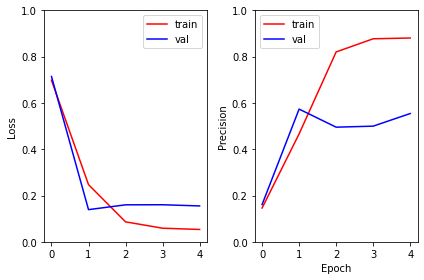

FOLD = 1
FOLD = 2
FOLD = 3
FOLD = 4


In [7]:
AUDIO_FOLDER = '../input/rfcx-species-audio-detection'

# Load the meta-file
META_FILE = pd.read_csv(f'{AUDIO_FOLDER}/train_tp.csv')

# We only use with a small fraction of the available data (1000 audio recordings) for now ...
META_FILE = META_FILE.iloc[:1000]

# Split the data into train and validation using StratifiedKFold...
from sklearn.model_selection import StratifiedKFold as skf
kfold = skf(n_splits=5, shuffle=True, random_state=32)
record_ids = META_FILE['recording_id'].tolist()
species_ids = META_FILE['species_id'].tolist()

for fold, (train_indices, val_indices) in enumerate(
    kfold.split(record_ids, species_ids)
):        
    print('FOLD =', fold)
    # Only using fold 0...
    if fold == 0:
        # Load Training dataset...
        TRAIN_META_FILE = META_FILE.iloc[train_indices] 
        Preprocessing(TRAIN_META_FILE).train_data()
        train_ds = Dataset(TRAIN=True)
        train_dl = DataLoader(train_ds, batch_size = 16, shuffle = True, num_workers = 0)

        # Load Validation data ...
        VAL_META_FILE = META_FILE.iloc[val_indices]
        Preprocessing(VAL_META_FILE).val_data()                       
        val_ds = Dataset(TRAIN=False) 
        val_dl = DataLoader(val_ds, batch_size=8, shuffle = False, drop_last = True)
                
        # Perform training and validation...
        Train_Validate(fold).fit(train_dl, val_dl)

# Concluding Remarks

Further improvement in the result can be achieved by adding 1. `image augmentations` 2. `mixup`

In [8]:
! rm -rf TRAIN_IMAGES
! rm -rf VAL_IMAGES

# END